# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The code in this notebook contains a neural network that is trained on pictures from the German Traffic Sign Recognition Benchmark database (http://benchmark.ini.rub.de/).

---
## Step 0: Load The Data

In [16]:
# Load pickled data
import pickle

# Loading the training and testing data

training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [17]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of a traffic sign image
image_shape = X_train[0].shape

# Determine how many unique classes/labels there are in the dataset.
labels_set = set()

for y in y_train:
    labels_set.add(y) 

n_classes = len(labels_set)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


We start by plotting ten randomly chosen images from the training set, alongside their labels (numeric and description).

In [42]:
# Create dictionary matching the label number to the label description
import csv

signnames_dict = {}

with open('signnames.csv') as csvfile :
    signnames_reader = csv.DictReader(csvfile)
    for row in signnames_reader :
        label_num = row['ClassId']
        label_desc = row['SignName']
        signnames_dict[label_num] = label_desc

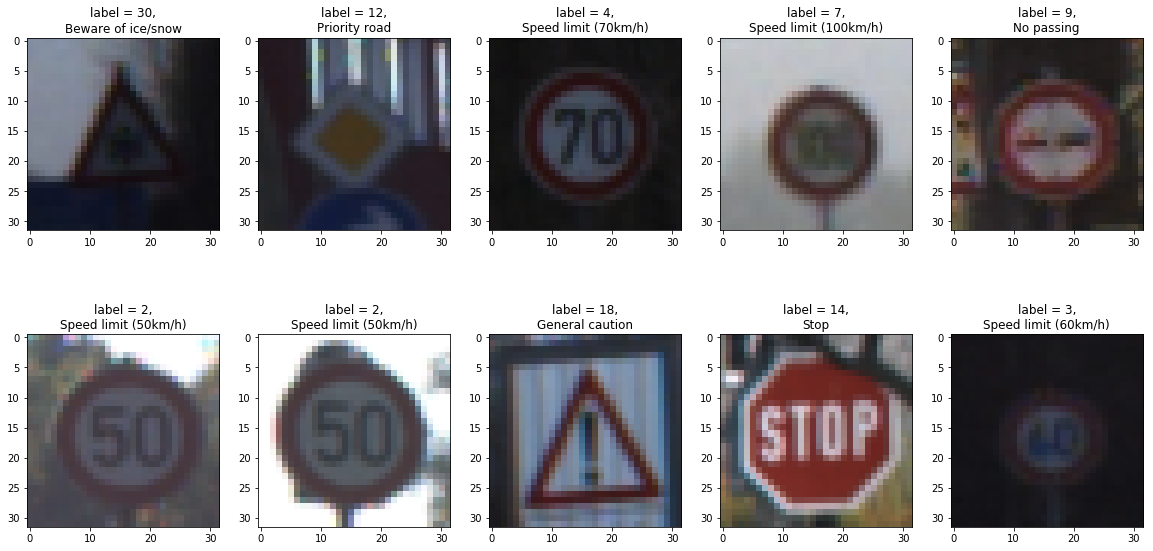

In [4]:
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize=(20,10))
#Visualize 10 images in training set
for i in range(10):
    plt.subplot(2,5,i+1)
    image_number = random.randint(0,n_train)
    label = str(y_train[image_number])
    desc = signnames_dict[label]
    plt.title('label = ' + label + ',\n' + desc)
    plt.imshow(X_train[image_number,:,:,:])

In order to analyse how often each individual sign occurs in the training set, we plot the histogram of the labels in the training set.

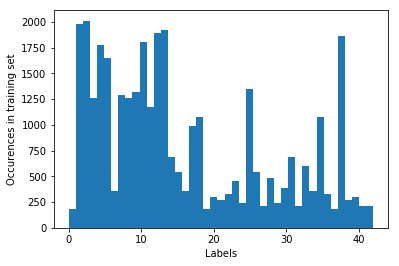

In [5]:
# create histogram to see how often each label occurs in the training data

occurences, _, _ = plt.hist(y_train, n_classes)
plt.xlabel('Labels')
plt.ylabel('Occurences in training set')
plt.show()

## Step 2: Generating additional data for the training set

As can be seen, not all traffic signs appear equally often in the training data. We thus create additional input data from the images in the training set by
- Rotating the image by a random angle (between -15° and 15°) around its center;
- Doing an affine transformation between three source points on the edges of the image and randomly choosen destination points;
- Rescaling the image by a random factor in between 0.9 and 1.2;

In order to implement these random transformations, we use OpenCV and follow this tutorial:
https://docs.opencv.org/master/d4/d61/tutorial_warp_affine.html

In [6]:
import numpy as np
import cv2

# define randomized affine transformation to generate additional input data

def affine_transformation(image):
    
    # Source points on the image edges
    src_points = np.array( [[0, 0], [image.shape[1] - 1, 0], [0, image.shape[0] - 1]] ).astype(np.float32)
    
    # Randomized destination points
    dst_points = np.array( [[0, image.shape[1]*random.uniform(0, 0.2)],
                            [image.shape[1]*random.uniform(0.8, 1), image.shape[0]*random.uniform(0, 0.2)],
                            [image.shape[1]*random.uniform(0, 0.2), image.shape[0]*random.uniform(0.8, 1)]]
                         ).astype(np.float32)
    
    # Get the transformation matrix from the source and destination points
    warp_mat = cv2.getAffineTransform(src_points, dst_points)
    # Do the transformation
    warp_dst = cv2.warpAffine(image, warp_mat, (image.shape[1], image.shape[0]))
    
    # Rotating the image after Warp
    
    # Center of the rotation is the center of the image
    center = (warp_dst.shape[1]//2, warp_dst.shape[0]//2)
    # Random angle between -15 and 15 degrees
    angle = random.uniform(-15,15)
    # Random scaling factor between 0.9 and 1.2
    scale = random.uniform(0.9,1.2)
    
    # Get the matrix for rotation/scaling
    rot_mat = cv2.getRotationMatrix2D( center, angle, scale)
    # Do the transformation
    warp_rotate_dst = cv2.warpAffine(warp_dst, rot_mat, (warp_dst.shape[1], warp_dst.shape[0]))
    
    return warp_rotate_dst

The goal in increasing the training data is twofold:
1. Have a more balanced training data set where every class occurs approximately equally often.
2. Increase the total size of the training data set. This increases of course the time the network takes to train but was found empirically to be the biggest lever to improve accuracy of the model.

In the paper http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf a training data set of size 126 750 is used, so we generate data until every class has 3000 examples on average, meaning that the training data set has ~43*3000 = 129 000 samples.
Note: Aming for more examples per class than even the most frequent classes in above histogram makes the code below over-engineering. This code was written to add additional data only in those classes that are less frequent. I chose to keep it anyways.

In [7]:
# create dictionary from histogram
histogram_dict = {}

for label, number in enumerate(occurences):
    histogram_dict[label] = number

In [8]:
from pandas import Series

# Define empty lists for the additional training data samples and labels
X_train_additional = []
y_train_additional = []

# define goal number of occurences
goal = 3000

# Continue while target average value of samples per class is not reached
while Series(histogram_dict[k] for k in histogram_dict).mean() < goal:
    # Loop over input data set
    for i in range(n_train):
        # get the label
        label = y_train[i]
        # get number of occcurences
        occ = histogram_dict[label]
        # define probability to generate new random image
        # (probability is relative distance from targest value of examples for that specific class)
        prob = (goal - occ)/goal if (goal - occ)/goal > 0 else 0
        # With probability prob generate a new image
        if np.random.choice(2,1, p=[1-prob, prob]):
            # Generate new image by applying the randomized affine transformation function
            add_image = affine_transformation(X_train[i, :, :, :])
            # Append the new image to the X_train_additional list
            X_train_additional.append(add_image)
            # Append the label to the y_train_additional list
            y_train_additional.append(label)
            # Increase histogram by one
            histogram_dict[label] += 1

# Make X_train_additional an array
X_train_additional = np.asarray(X_train_additional)
# Reshape
X_train_additional = X_train_additional.reshape((-1, image_shape[0], image_shape[1], 3))

Plot a random subset of the addtional input images:

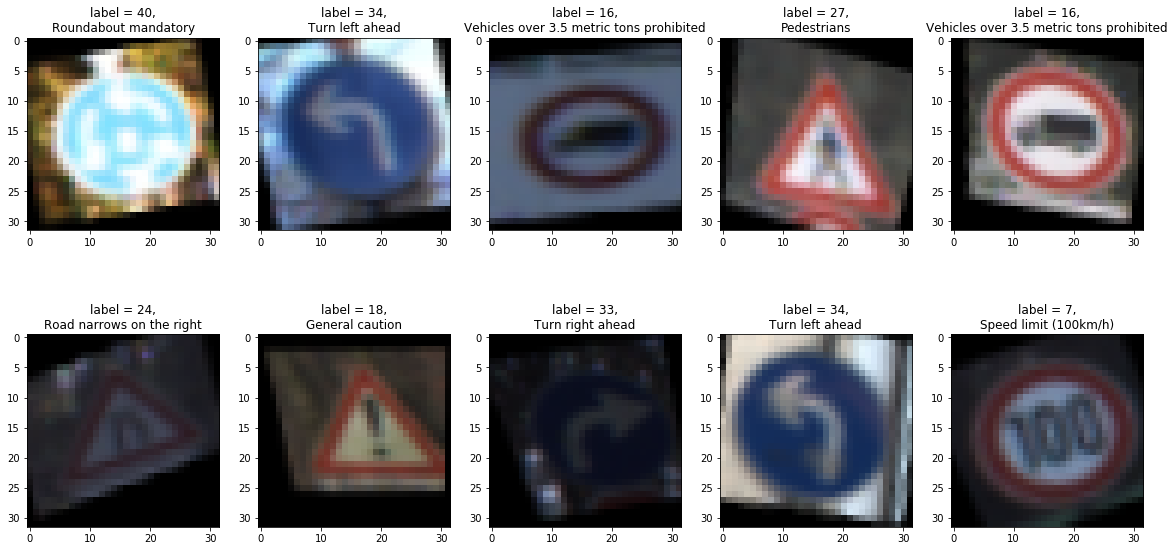

In [9]:
%matplotlib inline

plt.figure(figsize=(20,10))

for i in range(10):
    image_number = random.randint(0,X_train_additional.shape[0])   
    plt.subplot(2,5,i+1)  
    label = str(y_train_additional[image_number])
    desc = signnames_dict[label]
    plt.title('label = ' + label + ',\n' + desc)
    plt.imshow(X_train_additional[image_number])

In [10]:
# Concatenate original training set with the additional images
X_train_extended = np.concatenate((X_train, X_train_additional), axis=0)
y_train_extended = np.concatenate((y_train, y_train_additional), axis=0)
n_train_extended = len(X_train_extended)

Plot ten random images from the total (extended) training data set:

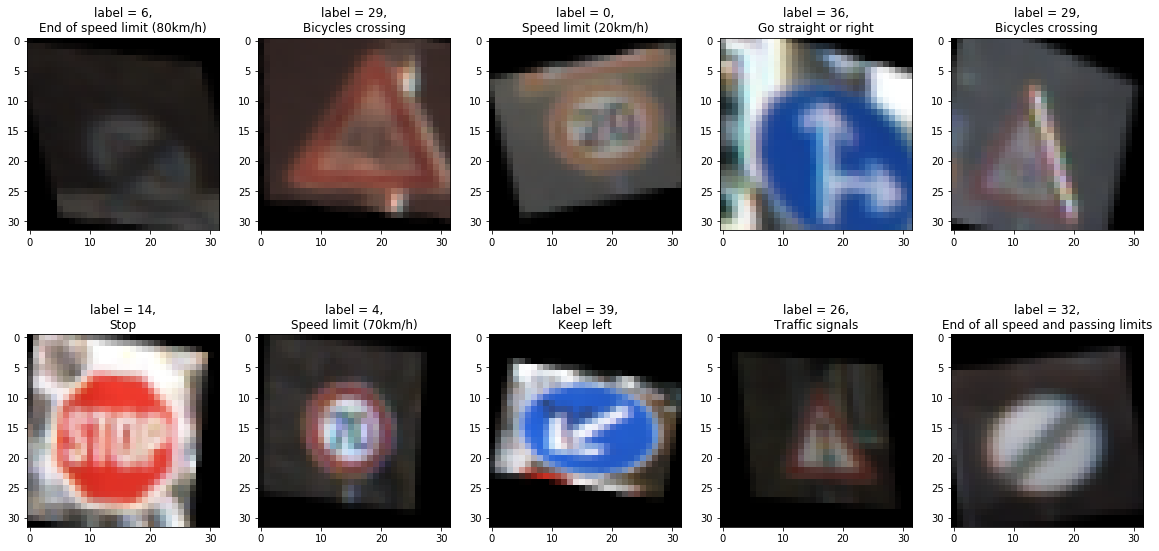

In [11]:
%matplotlib inline

plt.figure(figsize=(20,10))

for i in range(10):
    image_number = random.randint(0,X_train_extended.shape[0])   
    plt.subplot(2,5,i+1)  
    label = str(y_train_extended[image_number])
    desc = signnames_dict[label]
    plt.title('label = ' + label + ',\n' + desc)
    plt.imshow(X_train_extended[image_number])

Plot the histogram of the extended data set:

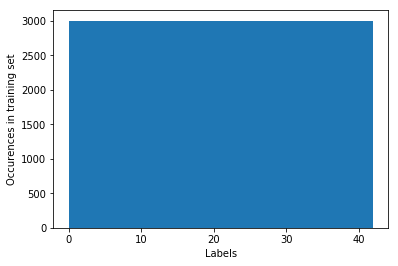

Total number of images in training set:  129000


In [12]:
# create histogram to see how often each label occurs in the training data

occurences, _, _ = plt.hist(y_train_extended, n_classes)
plt.xlabel('Labels')
plt.ylabel('Occurences in training set')
plt.show()
print("Total number of images in training set: ", n_train_extended)

As expected the histogram is flat now and the new size of the training data is 129 000.

----

## Step 3: Design and Test a Model Architecture


### Pre-process the Data Set (histogram equalization, transformation to YCrCb color space & normalization)

Data needs to be preprocessed. We transform to YCrCb color space, as was done in http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf (precisely they use YUV but this is very similar).

We then apply histogram equalization to the Y channel of the YCrCb image (this corresponds to a gray scale image), to improve contrast (see this tutorial: https://docs.opencv.org/master/d5/daf/tutorial_py_histogram_equalization.html). I tried the OpenCV functions `equalizeHist()` and `createCLAHE()` (CLAHE = Contrast Limited Adaptive Histogram Equalization). As CLAHE yielded better results, I kept it. The difference is that `equalizeHist()` does histogram equalization on the whole image while CLAHE divides the image in smaller tiles and then equalizes the histogram of each tile individually. 

We also normalize the data so that it has mean zero and equal variance.

In [19]:
import cv2
import numpy as np

def image_preprocessing(X):
    
    # get CLAHE
    clahe = cv2.createCLAHE()

    X_ycrcb = []

    for i in range(len(X)):
        # transform to YCrCb color space
        ycrcb = cv2.cvtColor(np.array(X[i]), cv2.COLOR_RGB2YCrCb)
        # apply CLAHE to the Y-channel (luma component)
        ycrcb[:,:,0] = clahe.apply(ycrcb[:,:,0])
        X_ycrcb.append(ycrcb)

    # reshape
    X_ycrcb = np.asarray(X_ycrcb)
    X_ycrcb = X_ycrcb.reshape((-1, image_shape[0], image_shape[1], 3))
    
    # Normalize
    X_ycrcb_normalized = (X_ycrcb - 128)/128
    
    return X_ycrcb, X_ycrcb_normalized

In [14]:
X_train_ycrcb, X_train_norm = image_preprocessing(X_train_extended)

In [20]:
_, X_valid_norm = image_preprocessing(X_valid)

In [21]:
_, X_test_norm = image_preprocessing(X_test)

We visualize ten random Y channel images of the training data.

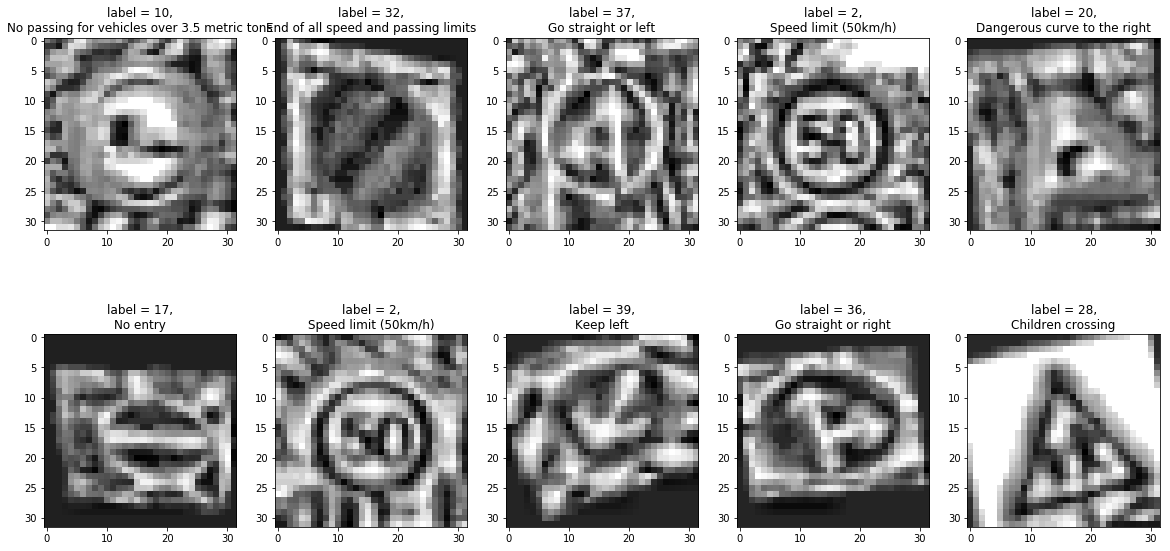

In [17]:
plt.figure(figsize=(20,10))
#Visualize 10 images in training set
for i in range(10):
    plt.subplot(2,5,i+1)
    image_number = random.randint(0,n_train_extended)
    label = str(y_train_extended[image_number])
    desc = signnames_dict[label]
    plt.title('label = ' + label + ',\n' + desc)
    plt.imshow(X_train_ycrcb[image_number,:,:,0], cmap='gray')

Plot ten random examples of the normalized training images.

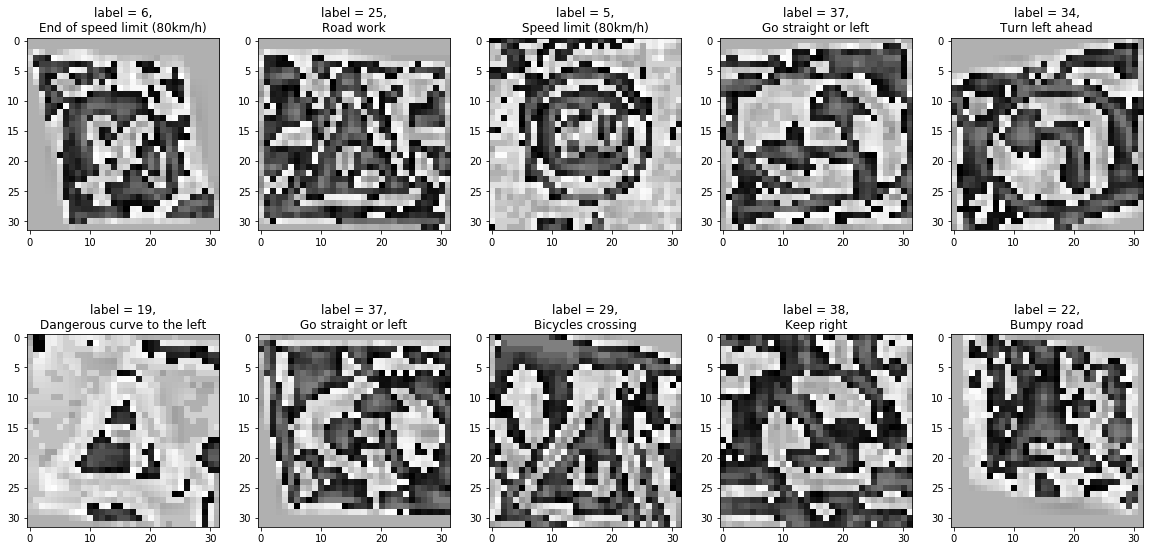

In [18]:
plt.figure(figsize=(20,10))
#Visualize 10 images in training set
for i in range(10):
    plt.subplot(2,5,i+1)
    image_number = random.randint(0,n_train_extended)
    label = str(y_train_extended[image_number])
    desc = signnames_dict[label]
    plt.title('label = ' + label + ',\n' + desc)
    plt.imshow(X_train_norm[image_number,:,:,0], cmap='gray')

### Model Architecture

In [19]:
from sklearn.utils import shuffle
import tensorflow as tf

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 128

The architecture used in this model is based on the LeNet5 architecture (http://yann.lecun.com/exdb/lenet/). In order to increase accuracy I made the following adaptions:
- Increase the number of features in the convolutional layers from 6 resp. 16 to 108 resp. 100. In the first layer 100 features are connected to the Y channel and 8 features are connected to the CrCb channels. (This idea was taken from http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 
- Use maximum pooling instead of subsampling.
- Add a drop out with keep probability 0.7 after the first and second fully connected layer.
- Adapt the output dimension of the last layer to the number of classes in the training data set.

In total, we have the following architecture:

 <table style="width:70%">
  <tr>
    <th>Layer</th>
    <th>Type</th>
    <th> Input dimensions</th>
    <th> Output dimensions</th>
  </tr>
  <tr>
    <td>1</td>
    <td>Convolutional</td>
    <td>32x32x1(2)</td>
    <td>28x28x100(8)</td>
  </tr>
  <tr>
    <td></td>
    <td>Stacking</td>
    <td>28x28x100 + 28x28x8</td>
    <td>28x28x108</td>
  </tr>
  <tr>
    <td></td>
    <td>Activation (ReLu)</td>
    <td>28x28x108</td>
    <td>28x28x108</td>
  </tr>
  <tr>
    <td></td>
    <td>Pooling</td>
    <td>28x28x108</td>
    <td>14x14x108</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Convolutional</td>
    <td>14x14x108</td>
    <td>10x10x100</td>
  </tr>
  <tr>
    <td></td>
    <td>Activation (ReLu)</td>
    <td>10x10x100</td>
    <td>10x10x100</td>
  </tr>
  <tr>
    <td></td>
    <td>Pooling</td>
    <td>10x10x100</td>
    <td>5x5x100</td>
  </tr>
  <tr>
    <td></td>
    <td>Flattening</td>
    <td>5x5x100</td>
    <td>2500</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Fully connected</td>
    <td>2500</td>
    <td>120</td>
  </tr>
  <tr>
    <td></td>
    <td>Activation (ReLu)</td>
    <td>120</td>
    <td>120</td>
  </tr>
  <tr>
    <td></td>
    <td>Dropout</td>
    <td>120</td>
    <td>120</td>
  </tr>
  <tr>
    <td>4</td>
    <td>Fully connected</td>
    <td>120</td>
    <td>84</td>
  </tr>
  <tr>
    <td></td>
    <td>Activation (ReLu)</td>
    <td>84</td>
    <td>84</td>
  </tr>
  <tr>
    <td></td>
    <td>Dropout</td>
    <td>84</td>
    <td>84</td>
  </tr>
  <tr>
    <td>5</td>
    <td>Fully connected</td>
    <td>84</td>
    <td>43</td>
  </tr>
</table> 

In the paper http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf, the authors mention that feeding the output of the first convolutional layer directly to the classifier (fully connected layers) alongside the output from the second convolutional layer improves accuracy. This seems logical as it allows the classifier to use low-level features (from the first CNN layer) as well as high-level features (from the second CNN layer). I implemented this idea but could not observe any increase in accuracy, so I decided to drop it.

In [29]:
# define the LeNet architecture

def LeNet(x_Y, x_CrCb):
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # keep probability for the drop outs
    keep_prop = 0.7
    
    # Layer 1 (Y-channel): Convolutional. Input = 32x32x1. Output = 28x28x100.
    weights_layer_1_y = tf.Variable(tf.truncated_normal([5,5,1,100], mean=mu, stddev=sigma))
    bias_layer_1_y = tf.Variable(tf.truncated_normal([100], mean=mu, stddev=sigma))
    strides_layer_1 = [1,1,1,1]
    padding_layer_1 = 'VALID'
    
    output_layer_1_y = tf.nn.conv2d(x_Y, weights_layer_1_y, strides_layer_1, padding_layer_1) + bias_layer_1_y
    
    # Layer 1 (CrCb-channels): Convolutional. Input 32x32x2. Output = 28x28x8
    weights_layer_1_crcb = tf.Variable(tf.truncated_normal([5,5,2,8], mean=mu, stddev=sigma))
    bias_layer_1_crcb = tf.Variable(tf.truncated_normal([8], mean=mu, stddev=sigma))
    
    output_layer_1_crcb = tf.nn.conv2d(x_CrCb, weights_layer_1_crcb, strides_layer_1, padding_layer_1) \
        + bias_layer_1_crcb
    
    # Stacking: Output = 28x28x108
    output_layer_1 = tf.concat((output_layer_1_y, output_layer_1_crcb), axis=3)

    # Activation.
    output_layer_1 = tf.nn.relu(output_layer_1)

    # Pooling. Input = 28x28x108. Output = 14x14x108.
    output_layer_1 = tf.nn.max_pool(output_layer_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # Layer 2: Convolutional. Output = 10x10x100.
    weights_layer_2 = tf.Variable(tf.truncated_normal([5,5,108,100], mean=mu, stddev=sigma))
    bias_layer_2 = tf.Variable(tf.truncated_normal([100], mean=mu, stddev=sigma))
    strides_layer_2 = [1,1,1,1]
    padding_layer_2 = 'VALID'
    
    output_layer_2 = tf.nn.conv2d(output_layer_1, weights_layer_2, strides_layer_2, padding_layer_2) + bias_layer_2
    
    # Activation.
    output_layer_2 = tf.nn.relu(output_layer_2)

    # Pooling. Input = 10x10x100. Output = 5x5x100.
    output_layer_2 = tf.nn.max_pool(output_layer_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # Flatten. Input = 5x5x100. Output = 2500.
    out_2_flat = tf.reshape(output_layer_2, [-1,2500])
    
    # Layer 3: Fully Connected. Input = 2500. Output = 120.
    weights_layer_3 = tf.Variable(tf.truncated_normal([2500,120], mean=mu, stddev=sigma))
    bias_layer_3 = tf.Variable(tf.truncated_normal([120], mean=mu, stddev=sigma))
    
    output_layer_3 = tf.add(tf.matmul(out_2_flat, weights_layer_3), bias_layer_3)
    
    # Activation.
    output_layer_3 = tf.nn.relu(output_layer_3)
    
    # Dropout
    output_layer_3 = tf.nn.dropout(output_layer_3, keep_prop)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    weights_layer_4 = tf.Variable(tf.truncated_normal([120,84], mean=mu, stddev=sigma))
    bias_layer_4 = tf.Variable(tf.truncated_normal([84], mean=mu, stddev=sigma))
    
    output_layer_4 = tf.add(tf.matmul(output_layer_3, weights_layer_4), bias_layer_4)
    
    # Activation.
    output_layer_4 = tf.nn.relu(output_layer_4)
    
    # Dropout
    output_layer_4 = tf.nn.dropout(output_layer_4, keep_prop)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes
    weights_layer_5 = tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma))
    bias_layer_5 = tf.Variable(tf.truncated_normal([n_classes], mean=mu, stddev=sigma))
    
    logits = tf.add(tf.matmul(output_layer_4, weights_layer_5), bias_layer_5)
    
    return logits

### Train, Validate and Test the Model

In [33]:
training_set = X_train_norm
training_labels = y_train_extended
validation_set = X_valid_norm
test_set = X_test_norm

NameError: name 'X_train_norm' is not defined

In [31]:
# prepare placeholder variables for training
x_Y = tf.placeholder(tf.float32, (None, 32, 32, 1))
x_CrCb = tf.placeholder(tf.float32, (None, 32, 32, 2))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [32]:
# define the training pipeline

# learning rate
initial_rate = 0.001
rate = initial_rate
# the logits are the output of the LeNet architecture
logits = LeNet(x_Y, x_CrCb)
# calculate the cross entropy of the logits
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
# the loss is the mean of the cross entropy over all inputs
loss_operation = tf.reduce_mean(cross_entropy)
# we use Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
# training is done by minimizing the loss
training_operation = optimizer.minimize(loss_operation)

In [24]:
# Define evaluation function

# correct prediction is true, if the same bit is "hot" in the logits as it is in the labels
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
# accuray is the mean of the "correctness" of all predictions
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define function used to evaluate the model
def evaluate(X_data, y_data):
    
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        # Cut the data in batches
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # for each batch, seperate the y and crcb channels
        batch_x_y = batch_x[:,:,:,0].reshape((-1, image_shape[0], image_shape[1], 1))
        batch_x_crcb = batch_x[:,:,:,1:3].reshape((-1, image_shape[0], image_shape[1], 2))
        # calculate accuracy for one batch
        accuracy = sess.run(accuracy_operation, feed_dict={x_Y: batch_x_y, x_CrCb: batch_x_crcb, y: batch_y})
        # add and average batch accuracies to get total accuracy
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training the neural network. We use learning rate decay with a Drop-Based Learning Rate Schedule
(see here: https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)

In [36]:
import math
# define a saver to save the model after training
saver = tf.train.Saver()
accuracies = []

In [ ]:
# training of model
with tf.Session() as sess:
    # initialize global variables
    sess.run(tf.global_variables_initializer())
    num_examples = len(training_set)
    
    print("Training...")
    print()
    
    # loop over the epochs
    for i in range(EPOCHS):
        
        # at the beginning of each epoch, shuffle the training data set
        training_set, training_labels = shuffle(training_set, training_labels)
        
        # loop over batches
        for offset in range(0, num_examples, BATCH_SIZE):
            
            # Cut the data in batches
            end = offset + BATCH_SIZE
            batch_x, batch_y = training_set[offset:end], training_labels[offset:end]
            # for each batch, seperate the y and crcb channels
            batch_x_y = batch_x[:,:,:,0].reshape((-1, image_shape[0], image_shape[1], 1))
            batch_x_crcb = batch_x[:,:,:,1:3].reshape((-1, image_shape[0], image_shape[1], 2))
            
            # run the training operation on each batch
            sess.run(training_operation, feed_dict={x_Y: batch_x_y, x_CrCb: batch_x_crcb, y: batch_y})
        
        # For each epoch validate the accuracy
        validation_accuracy = evaluate(validation_set, y_valid)
        accuracies.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        print("Learning rate = {:.2E}".format(rate))
        drop = 0.8
        epochs_drop = 10.0
        rate = initial_rate * math.pow(drop, math.floor((1+i)/epochs_drop))

    
    # save model after training
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.367

Learning rate = 1.00E-03


Plot the accuracy with respect to the training epoch:

In [ ]:
epochs = np.array(range(1, EPOCHS+1))
goal_accuracy = 0.93*np.ones(range(1, EPOCHS+1))
plt.plot(epochs, accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

Test the saved model on the test set:

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_set, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 4: Test a Model on New Images

We now test the model on new images from the internet (not contained in the GTSRB data base)

### Load and Output the Images

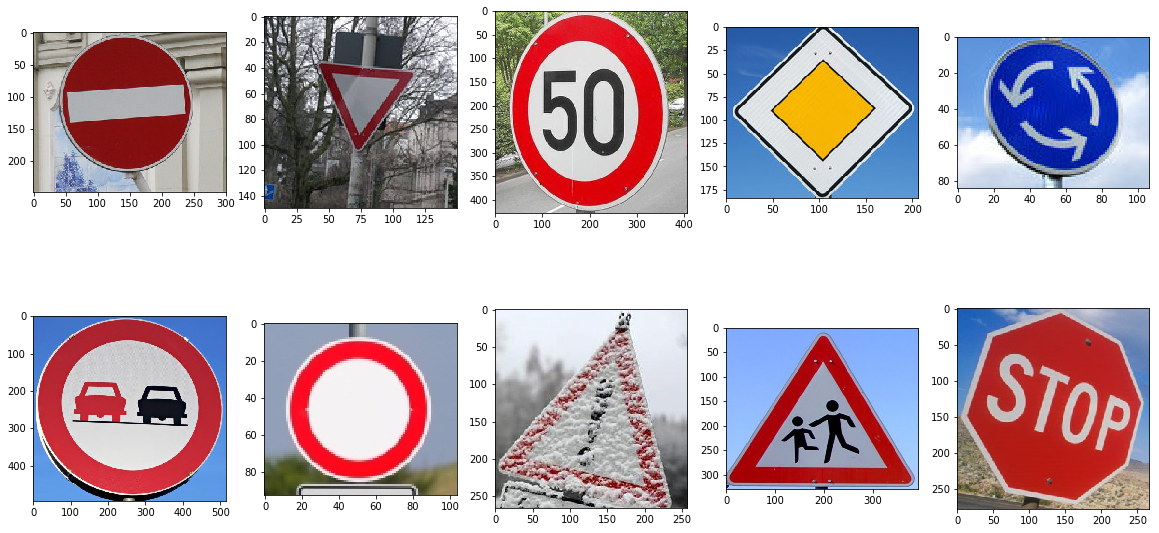

In [155]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

# read in all images with names with pattern *.jpg
images = glob.glob('../additional_examples/*.jpg')

add_images = []

# loop over images
for file_name in images:
    add_images.append(mpimg.imread(file_name))

plt.figure(figsize=(20,10))

for i in range(10):  
    plt.subplot(2,5,i+1)
    plt.imshow(add_images[i])

Create the labels of these examples:

In [156]:
import tensorflow as tf
labels_add_images = [17, 13, 2, 12, 40, 9, 15, 18, 28, 14]

Resize images to size 32x32:

In [157]:
import cv2

resized_images = []

for image in add_images:
    resized_images.append(cv2.resize(image, (32,32)))
    

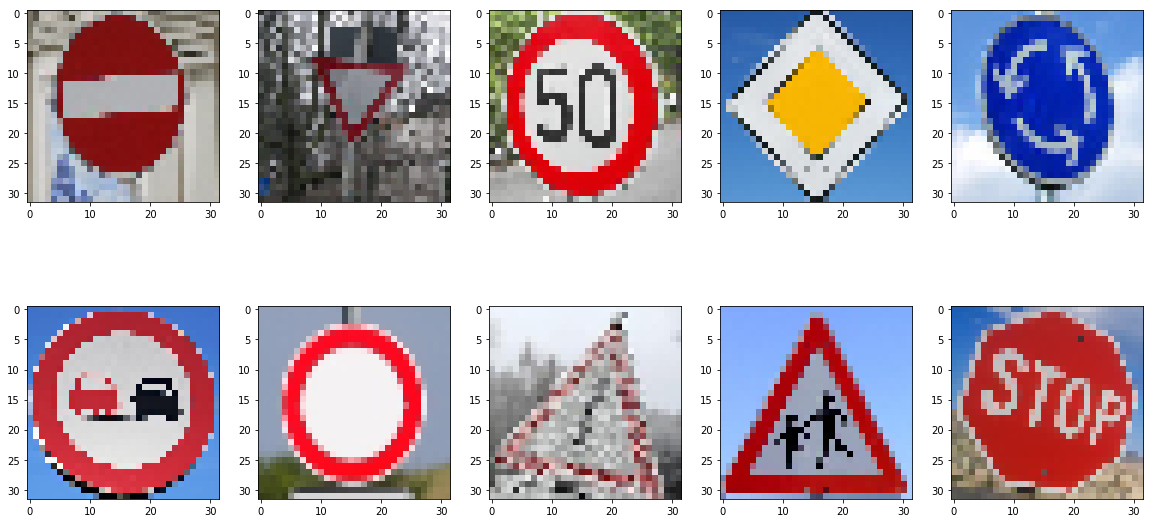

In [158]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,10))

for i in range(10):  
    plt.subplot(2,5,i+1)
    plt.imshow(resized_images[i])

Before feeding these images into the model we must preprocess them:

In [159]:
add_images_ycrcb, add_images_norm = image_preprocessing(resized_images)

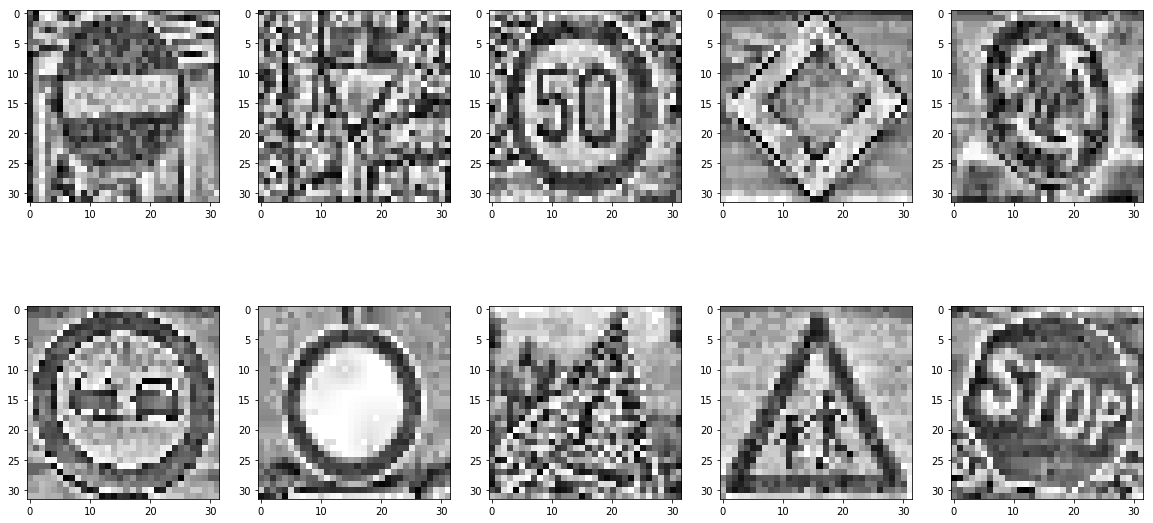

In [160]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,10))

for i in range(10):  
    plt.subplot(2,5,i+1)
    plt.imshow(add_images_ycrcb[i, :, :, 0], cmap='gray')

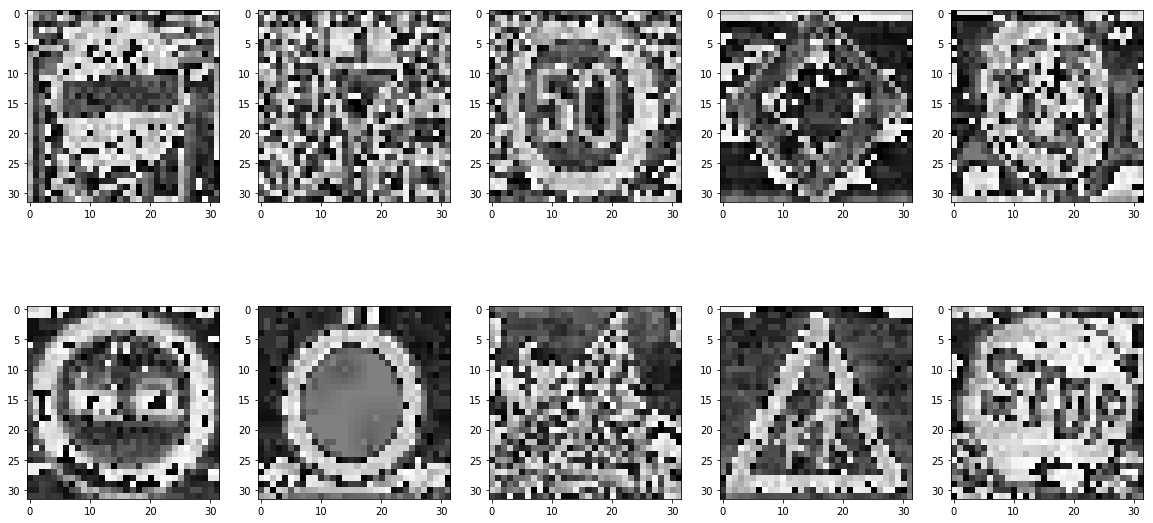

In [161]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,10))

for i in range(10):  
    plt.subplot(2,5,i+1)
    plt.imshow(add_images_norm[i, :, :, 0], cmap='gray')

### Predict the Sign Type for Each Image

In [162]:
def classifier(XY, XCrCb, sess):
    pred_class = sess.run(tf.argmax(logits, 1), feed_dict={x_Y: XY, x_CrCb: XCrCb})
    return pred_class

In [181]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    # for each batch, seperate the y and crcb channels
    XY = add_images_norm[:,:,:,0].reshape((-1, image_shape[0], image_shape[1], 1))
    XCrCb = add_images_norm[:,:,:,1:3].reshape((-1, image_shape[0], image_shape[1], 2))
    pred_classes = classifier(XY, XCrCb, sess)
    softmax_probs = tf.nn.top_k(pred_classes, k=3)
    sess.run(softmax_probs)

INFO:tensorflow:Restoring parameters from ./lenet


In [183]:
print(softmax_probs.values[0])

Tensor("strided_slice_4:0", shape=(), dtype=int64)


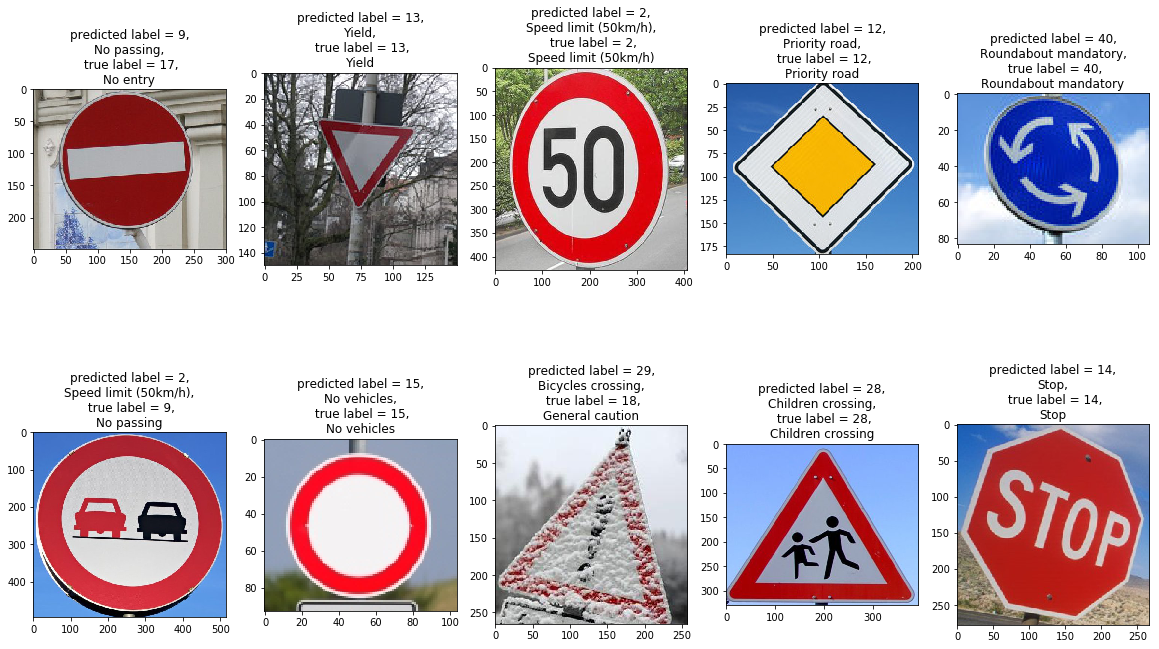

In [166]:
plt.figure(figsize=(20,12))

for i in range(10):
    plt.subplot(2,5,i+1)
    label = str(labels_add_images[i])
    desc = signnames_dict[label]
    pred_label = str(pred_classes[i])
    pred_desc = signnames_dict[pred_label]
    plt.title('predicted label = ' + pred_label + ',\n' + pred_desc + ',\n true label = ' + label + ',\n' + desc)
    plt.imshow(add_images[i])

### Analyze Performance

Out of the ten images the model gets eight correctly, meaning the accuracy is 80%.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 5 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")